In [ ]:
#시각화 한글 보여주기 -> 설치하고 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa 불러오기(파이썬 음성 분석 라이브러리) -> 음성시각화 및 벡터화 지원
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 오디오파일 재생 라이브러리
from IPython.display import Audio

#케라스 불러오기
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

#오류무시
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [13]:
#감성대화 음성데이터 압축풀기
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치(원천데이터)_음성데이터.zip"

In [9]:
#감성대화 라벨데이터 불러오기
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/감성대화/감성대화말뭉치_table.xlsx')
#감정 및 음성데이터경로만 뽑아오기
data2 = data.loc[:,['감정_대분류','NO.']]
data2.columns = ['Emotions','Path']
# 음성데이터 경로수정해주기(압축푼 폴더로)
data2['Path'] = '/content/emo_talk_source/'+data2['Path']+'.wav'

# 감정데이터중에 '당황'라벨 제거해주기
data_path = data2[data2['Emotions']!='당황']
data_path.head(10)

,Emotions,Path
0,상처,/content/emo_talk_source/M_000001.wav
1,상처,/content/emo_talk_source/M_000002.wav
2,상처,/content/emo_talk_source/M_000003.wav


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


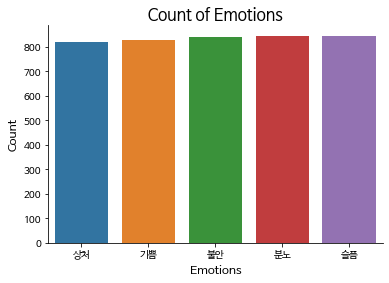

In [12]:
# 도표 및 그림에서 한글사용하기
plt.rc('font', family='NanumBarunGothic') 

# 감정의 전체적인 분포 확인하기
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
# 음성데이터를 waveplot, spectrogram 이미지로 표현

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft 함수는 음성을 시간기반에서 주파수기반으로 변환함
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


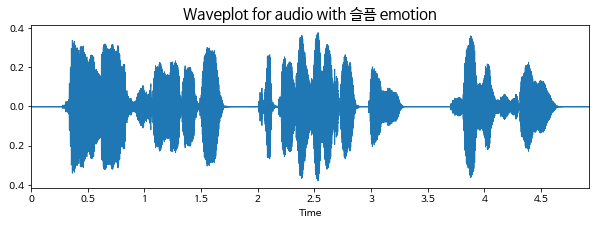

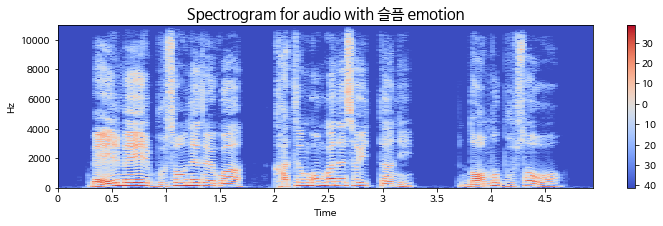

In [17]:
#슬픔 음성데이터 예시로 보기
emotion='슬픔'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [18]:
# 음성데이터 argumentation을 통해서 데이터 수 늘리기 및 오버피팅 방지
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# 예시
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# 음성의 특성추출하는 함수 ( MFCC, MEL, RMSV)

def extract_features(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
#    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

# 음성의 특성을 추출한 데이터를 축적하는 함수 (Argumentation된 데이터도 같이)
def get_features(path):
    # duration과 offset은 각 오디오 파일의 시작과 끝에서 오디오가 없는 것을 처리
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # 원래데이터
    res1 = extract_features(data)
    result = np.array(res1)
    # 노이즈가 추가된 데이터
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # 병렬적으로 추가

    # 피칭및 스트레칭된 데이터
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # 병렬적으로 추가

    return result

In [19]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # 2개의 augmentation이 존재하므로 총 한개의 음성데이터가 3개의 음성데이터가 됨
        Y.append(emotion)
        

In [21]:
len(X), len(Y), data_path.Path.shape

(12525, 12525, (4175,))

In [22]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,labels
0,-307.164398,112.814110,10.277925,20.770569,11.006676,1.595616,9.324680,3.455682,-9.324601,1.029835,-13.141382,-5.245862,-8.935234,1.860001,-4.593522,-6.008457,-7.606110,3.329404,-13.234294,-2.671186,0.018386,0.054422,1.731338,13.961040,16.975199,14.694365,3.449312,20.265163,22.679052,3.778708,1.635163,2.529157,2.474900,3.174746,1.864363,2.892532,6.749694,4.302821,2.811399,0.745582,...,0.039692,0.023108,0.010905,0.006015,0.004218,0.003648,0.004103,0.003477,0.001854,0.000893,0.001092,0.001378,0.001258,0.001014,0.001102,0.000931,0.001761,0.001890,0.001754,0.001147,0.001818,0.002114,0.001098,0.001065,0.001251,0.001617,0.004180,0.003982,0.002907,0.003169,0.002338,0.001410,0.002439,0.002661,0.001980,0.001812,0.001535,0.000449,0.000035,상처
1,-200.339300,55.718304,17.927976,13.487070,7.483146,3.193354,5.783374,-0.451784,-5.676826,-3.899771,-7.527323,-6.560140,-4.992605,-2.455937,-1.737132,-4.049068,-4.133984,-1.511963,-6.431041,-6.908499,0.021010,0.060376,1.728735,13.905012,16.985384,14.754493,3.459644,20.315134,22.721942,3.786813,1.637718,2.561946,2.505125,3.205068,1.876641,2.892397,6.726770,4.332695,2.818272,0.748429,...,0.042305,0.027438,0.016019,0.009978,0.008498,0.007624,0.008631,0.007350,0.005930,0.005018,0.004832,0.005544,0.005360,0.004987,0.005172,0.005114,0.005855,0.006101,0.006154,0.005371,0.006011,0.006298,0.005495,0.005534,0.005337,0.005767,0.008353,0.007822,0.007004,0.007120,0.006600,0.005333,0.006443,0.007206,0.006043,0.005940,0.005740,0.004521,0.004027,상처
2,-357.051392,110.258286,6.137347,21.094173,7.993587,0.733337,10.874974,-2.554489,-11.293797,-0.187203,-14.014192,-3.869906,-7.025927,2.820296,-6.779037,-6.367522,-5.043113,1.415788,-15.572018,-1.673853,0.007194,0.013779,0.221492,3.107707,3.775733,2.931848,0.938047,2.126662,4.930017,2.195517,0.204144,0.434527,0.531079,0.482063,0.417535,0.292604,1.420091,1.605137,0.585675,0.418538,...,0.007776,0.006825,0.005749,0.003233,0.001539,0.001177,0.001080,0.000887,0.000531,0.000421,0.000250,0.000153,0.000238,0.000263,0.000215,0.000171,0.000188,0.000343,0.000412,0.000361,0.000246,0.000283,0.000453,0.000290,0.000193,0.000243,0.000293,0.000570,0.001054,0.000841,0.000762,0.000691,0.000307,0.000349,0.000507,0.000492,0.000294,0.000075,0.000009,상처
3,-327.695923,85.970268,21.572702,26.052414,15.584455,4.870055,7.655095,7.034173,-3.060503,0.834559,-13.533870,-0.389866,-8.472123,0.829263,-3.138247,-0.697751,-6.468887,4.116869,-6.367004,-4.489249,0.021638,0.222258,3.587872,10.505693,6.887259,2.285403,5.596915,15.255266,15.839133,2.065081,0.660186,0.970613,2.172422,1.763036,0.929377,2.435689,9.747363,4.059102,0.344986,0.192219,...,0.023651,0.018445,0.006377,0.003347,0.003195,0.004399,0.008751,0.028066,0.028638,0.012397,0.006877,0.005601,0.007094,0.002892,0.005462,0.004041,0.007506,0.007545,0.005939,0.002615,0.003975,0.006060,0.004462,0.004761,0.005639,0.010940,0.010346,0.014490,0.011132,0.008663,0.006470,0.002632,0.004956,0.004633,0.004038,0.003725,0.001876,0.000781,0.000085,상처
4,-252.121817,52.955677,21.984184,22.877992,14.438934,3.725427,4.234709,3.700124,-2.301550,-3.670827,-9.979811,-3.263966,-5.839016,-1.911588,-1.260090,-1.296219,-4.909618,0.934355,-2.724353,-5.706448,0.023333,0.221994,3.587403,10.509907,6.890209,2.283564,5.588767,15.238457,15.839642,2.066939,0.659949,0.969391,2.173876,1.766502,0.927493,2.444241,9.759192,4.063618,0.348505,0.191878,...,0.025209,0.019962,0.007387,0.004208,0.003927,0.005212,0.009888,0.028452,0.029252,0.012917,0.007662,0.006376,0.008141,0.003808,0.006490,0.005148,0.008525,0.008348,0.006884,0.003551,0.004633,0.006610,0.005482,0.005933,0.006654,0.011839,0.011634,0.015666,0.011986,0.009599,0.007263,0.003537,0.005908,0.005654,0.005084,0.004652,0.002823,0.001779,0.000992,상처


In [23]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [24]:
# 다중 클래스 분류하기위해 Y설정
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
# 훈련데이터, 테스트데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9393, 148), (9393, 5), (3132, 148), (3132, 5))

In [26]:
# 훈련 및 테스트데이터 갯수 확인
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9393, 148), (9393, 5), (3132, 148), (3132, 5))

In [27]:
# 데이터의 차원 모델에 맞게 통일 
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9393, 148, 1), (9393, 5), (3132, 148, 1), (3132, 5))

In [28]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 148, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0

In [29]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.000005)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
147/147 [==============================] - 34s 24ms/step - loss: 1.5898 - accuracy: 0.2576 - val_loss: 1.5747 - val_accuracy: 0.2819
Epoch 2/100
147/147 [==============================] - 3s 19ms/step - loss: 1.5577 - accuracy: 0.2747 - val_loss: 1.5164 - val_accuracy: 0.3298
Epoch 3/100
147/147 [==============================] - 3s 19ms/step - loss: 1.5333 - accuracy: 0.2956 - val_loss: 1.5110 - val_accuracy: 0.3250
Epoch 4/100
147/147 [==============================] - 3s 19ms/step - loss: 1.5072 - accuracy: 0.2998 - val_loss: 1.4644 - val_accuracy: 0.3649
Epoch 5/100
147/147 [==============================] - 3s 19ms/step - loss: 1.4849 - accuracy: 0.3275 - val_loss: 1.4686 - val_accuracy: 0.3534
Epoch 6/100
147/147 [==============================] - 3s 19ms/step - loss: 1.4618 - accuracy: 0.3272 - val_loss: 1.4189 - val_accuracy: 0.3745
Epoch 7/100
147/147 [==============================] - 3s 19ms/step - loss: 1.4402 - accuracy: 0.3480 - val_loss: 1.3944 - val_accuracy

23/23 [==============================] - 1s 39ms/step - loss: 1.2743 - accuracy: 0.7972
Accuracy of our model on test data :  79.72221970558167 %


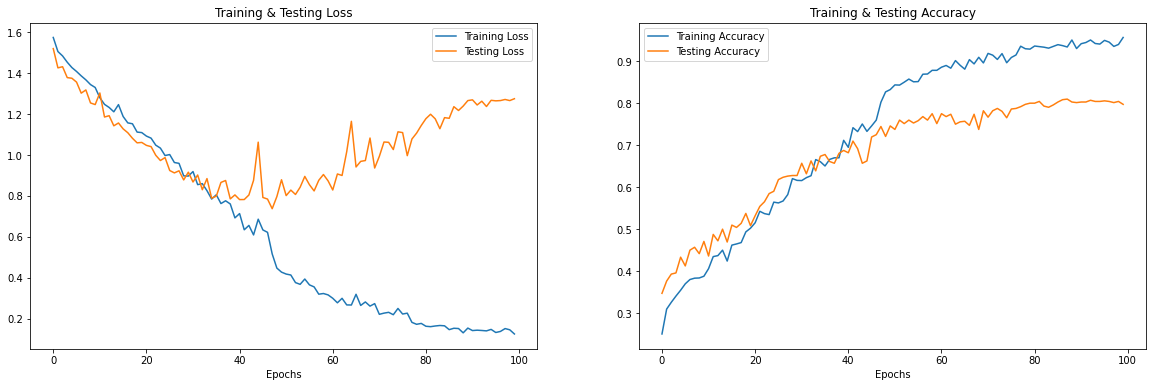

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:
# 테스트데이터 적용
pred_test = model.predict(x_test)
pred_test
y_pred = encoder.inverse_transform(pred_test)
y_test2 = encoder.inverse_transform(y_test)

In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test2

df.head(3)

,Predicted Labels,Actual Labels
0,기쁨,기쁨
1,기쁨,분노
2,기쁨,기쁨


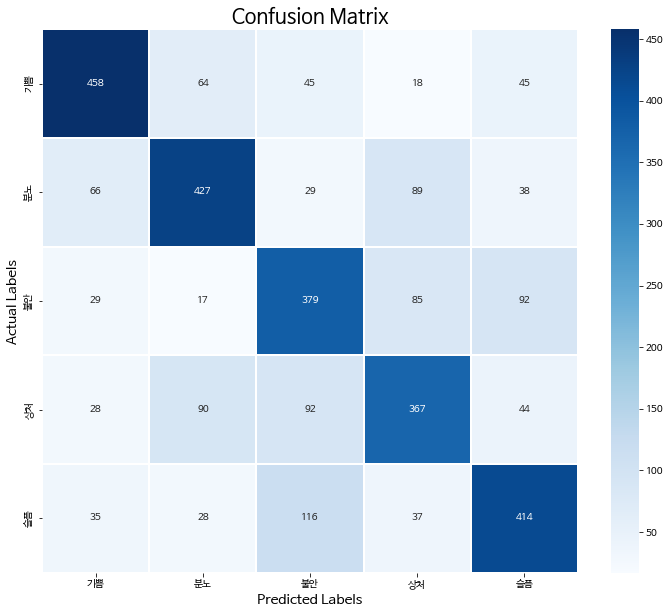

In [32]:
cm = confusion_matrix(y_test2, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

          기쁨       0.74      0.73      0.74       630
          분노       0.68      0.66      0.67       649
          불안       0.57      0.63      0.60       602
          상처       0.62      0.59      0.60       621
          슬픔       0.65      0.66      0.66       630

    accuracy                           0.65      3132
   macro avg       0.65      0.65      0.65      3132
weighted avg       0.65      0.65      0.65      3132

